In [1]:
import pandas as pd


comp_data = 'compiled_torque_july4.dat'

df = pd.read_csv(comp_data, sep='\t')
df

,rod_id,position,measurement_index,point_index,value
0,Rod2,endN1,0,0,0.00068
1,Rod2,endN1,0,1,0.00266
2,Rod2,endN1,0,2,0.00414
3,Rod2,endN1,0,3,0.00578
4,Rod2,endN1,0,4,0.00742
...,...,...,...,...,...
17795,Rod5,endN1,99,11,0.00085
17796,Rod5,endN1,99,12,0.00036
17797,Rod5,endN1,99,13,0.00019
17798,Rod5,endN1,99,14,0.00052


In [2]:
rod_chars = 'dataTorque/rod-lenght.txt'
dfC = pd.read_csv(rod_chars)

boat_position = 'dataTorque/boat-position.txt'
dfB = pd.read_csv(boat_position)


In [3]:
dfC, dfB

(                Rod         material  lenght diammeter
 0              Rod1               al   145mm     1.6mm
 1              Rod2               al   182mm     1.6mm
 2              Rod3               al   182mm     1.6mm
 3  Rod4 not working          unknown   163mm    1.47mm
 4              Rod5            glass   166mm     3.2mm
 5    Rod6 is broken   yellow plastic   164mm    1.61mm
 6              Rod7    clear plastic  180mm      2.9mm,
                 file_name  reference point  position
 0  Data_Rod2_endN1-070425           bridge     9.8cm
 1  Data_Rod2_endN1-070425           anchor      14cm
 2  Data_Rod3_endN1-070425           bridge     9.8cm
 3  Data_Rod5_endN1-070425           bridge     8.8cm
 4  Data_Rod7_endN1-070425           bridge     8.8cm
 5  Data_Rod7_endN2-070425           bridge    12.9cm
 6  Data_Rod1_endN1-070425           bridge     8.8cm)

In [4]:
# Filter out broken rods (optional)
dfC = dfC[dfC['Rod'].str.contains("Rod") & ~dfC['Rod'].str.contains("not working|broken", case=False)].copy()

# Standardize rod_id
dfC['rod_id'] = dfC['Rod'].str.extract(r'(Rod\d+)')
# Example file_name: Data_Rod2_endN1-070425
dfB['rod_id'] = dfB['file_name'].str.extract(r'(Rod\d+)')
dfB['position'] = dfB['file_name'].str.extract(r'(endN\d+)')




In [5]:
# First merge main df with rod characteristics
df_merged = pd.merge(df, dfC.drop(columns=['Rod']), on='rod_id', how='left')




In [6]:
# Then merge with position info from boat-position.txt
#df_merged = pd.merge(df_merged, dfB, on=['rod_id', 'position'], how='left')


In [7]:
df_merged

,rod_id,position,measurement_index,point_index,value,material,lenght,diammeter
0,Rod2,endN1,0,0,0.00068,al,182mm,1.6mm
1,Rod2,endN1,0,1,0.00266,al,182mm,1.6mm
2,Rod2,endN1,0,2,0.00414,al,182mm,1.6mm
3,Rod2,endN1,0,3,0.00578,al,182mm,1.6mm
4,Rod2,endN1,0,4,0.00742,al,182mm,1.6mm
...,...,...,...,...,...,...,...,...
17795,Rod5,endN1,99,11,0.00085,glass,166mm,3.2mm
17796,Rod5,endN1,99,12,0.00036,glass,166mm,3.2mm
17797,Rod5,endN1,99,13,0.00019,glass,166mm,3.2mm
17798,Rod5,endN1,99,14,0.00052,glass,166mm,3.2mm


  Rod ID        Material  Diameter (mm)  Length (mm)
0   Rod1              al            1.6          145
1   Rod2              al            1.6          182
2   Rod3              al            1.6          182
3   Rod5           glass            3.2          166
4   Rod7   clear plastic            2.9          180
\begin{tabular}{llll}
\toprule
Rod ID & Material & Diameter (mm) & Length (mm) \\
\midrule
Rod1 & al & 1.600000 & 145 \\
Rod2 & al & 1.600000 & 182 \\
Rod3 & al & 1.600000 & 182 \\
Rod5 &  glass & 3.200000 & 166 \\
Rod7 &  clear plastic & 2.900000 & 180 \\
\bottomrule
\end{tabular}



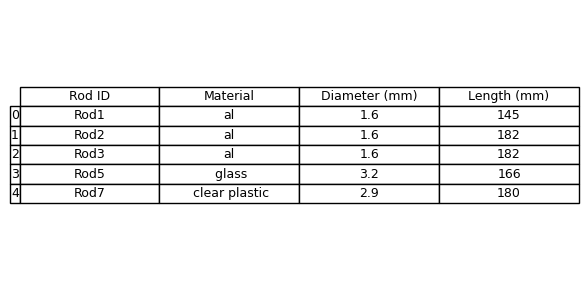

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import table as pd_table

# Standardize column names
df_merged = df_merged.rename(columns={'lenght': 'length', 'diammeter': 'diameter'})

# Extract and clean up unique characteristics
char_table = (
    df_merged[['rod_id', 'material', 'diameter', 'length']]
    .drop_duplicates()
    .sort_values('rod_id')
    .reset_index(drop=True)
)

# Remove units from values, assume they all end in 'mm'
char_table['diameter'] = char_table['diameter'].str.replace('mm', '').astype(float)
char_table['length'] = char_table['length'].str.replace('mm', '').astype(int)

# Rename columns to include units in headers
char_table.columns = ['Rod ID', 'Material', 'Diameter (mm)', 'Length (mm)']

# Print the table
print(char_table)

# Save as figure
fig, ax = plt.subplots(figsize=(6, len(char_table)*0.6))
ax.axis('off')
pd_table(ax, char_table, loc='center', cellLoc='center')
plt.tight_layout()
plt.savefig("rod_characteristics_table.png", dpi=300)

# Export to LaTeX
latex_table = char_table.to_latex(index=False, column_format='llll', escape=False)
print(latex_table)

# Optionally save LaTeX to file
with open("rod_characteristics_table.tex", "w") as f:
    f.write(latex_table)


In [9]:
summary_df = (
    df_merged
    .groupby(['material','rod_id', 'position', 'point_index'])
    .agg(
       mean_voltage=('value', 'mean'),
       std_voltage=('value', 'std')
    )
    .reset_index()
)
summary_df['torque_mg'] = summary_df['point_index'] * 50  # your X axis

# Optionally reorder columns
summary_df = summary_df[['material','rod_id', 'position', 'point_index', 'torque_mg', 'mean_voltage', 'std_voltage']]
# Strip whitespace and lowercase
summary_df['material'] = summary_df['material'].str.strip().str.lower()


summary_df

,material,rod_id,position,point_index,torque_mg,mean_voltage,std_voltage
0,clear plastic,Rod7,endN1,0,0,-0.001091,0.000132
1,clear plastic,Rod7,endN1,1,50,-0.000668,0.000147
2,clear plastic,Rod7,endN1,2,100,-0.000073,0.000131
3,clear plastic,Rod7,endN1,3,150,-0.000082,0.000127
4,clear plastic,Rod7,endN1,4,200,-0.001079,0.000118
...,...,...,...,...,...,...,...
157,al,Rod3,endN2,11,550,-0.020314,0.000132
158,al,Rod3,endN2,12,600,-0.022212,0.000145
159,al,Rod3,endN2,13,650,-0.024020,0.000132
160,al,Rod3,endN2,14,700,-0.025910,0.000139


In [10]:
summary_clear = summary_df[summary_df['material'] == 'clear plastic']
summary_clear

,material,rod_id,position,point_index,torque_mg,mean_voltage,std_voltage
0,clear plastic,Rod7,endN1,0,0,-0.001091,0.000132
1,clear plastic,Rod7,endN1,1,50,-0.000668,0.000147
2,clear plastic,Rod7,endN1,2,100,-0.000073,0.000131
3,clear plastic,Rod7,endN1,3,150,-0.000082,0.000127
4,clear plastic,Rod7,endN1,4,200,-0.001079,0.000118
5,clear plastic,Rod7,endN1,5,250,-0.000696,0.000138
6,clear plastic,Rod7,endN1,6,300,-0.000928,0.000134
7,clear plastic,Rod7,endN1,7,350,-0.000851,0.000136
8,clear plastic,Rod7,endN1,8,400,-0.000879,0.000134
9,clear plastic,Rod7,endN1,9,450,-0.000842,0.000121


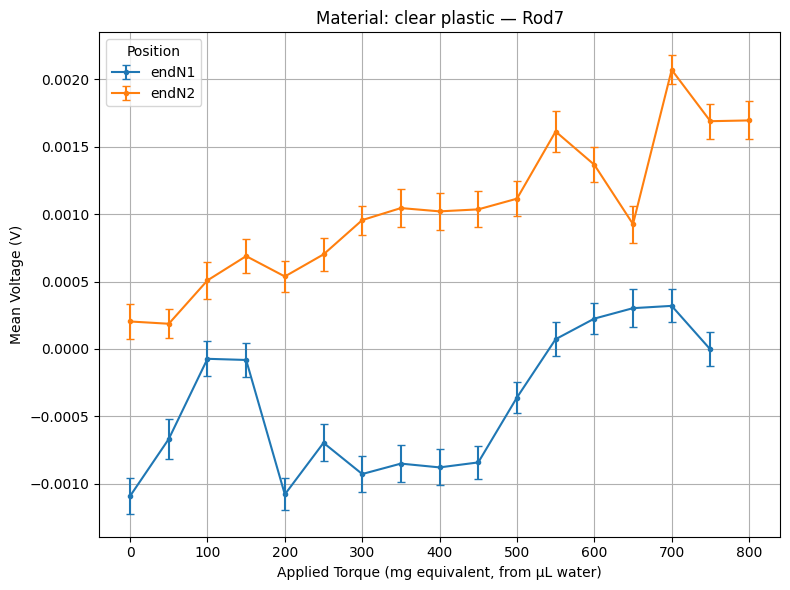

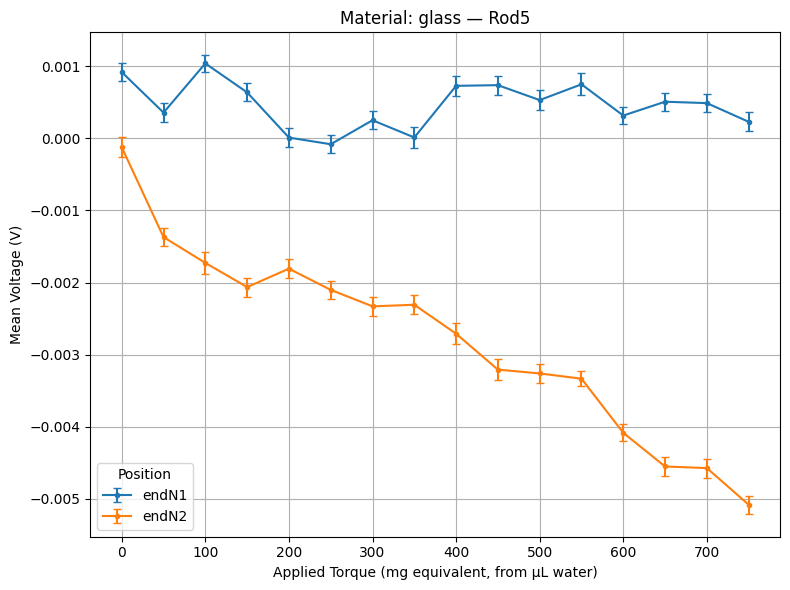

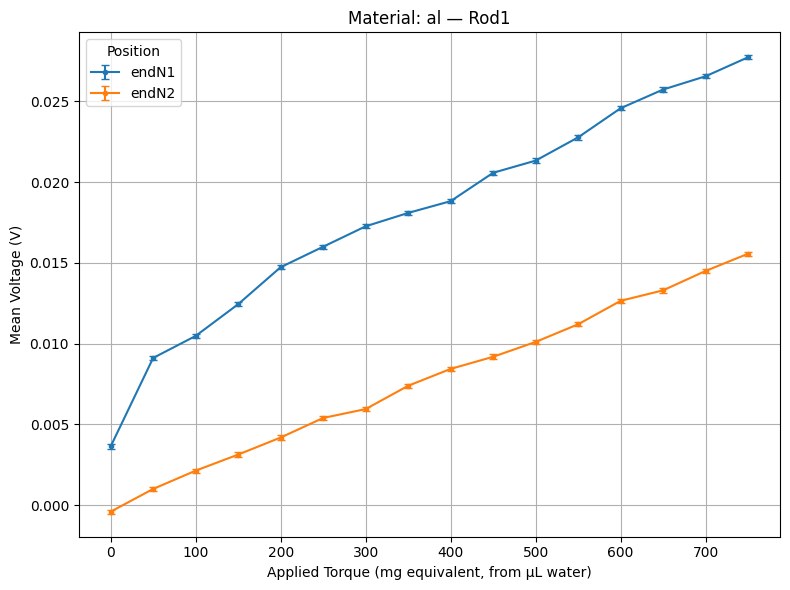

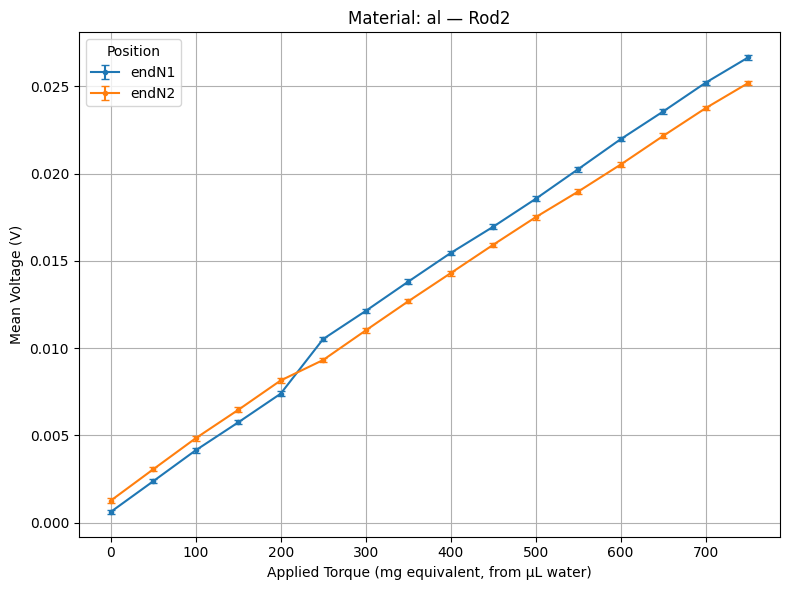

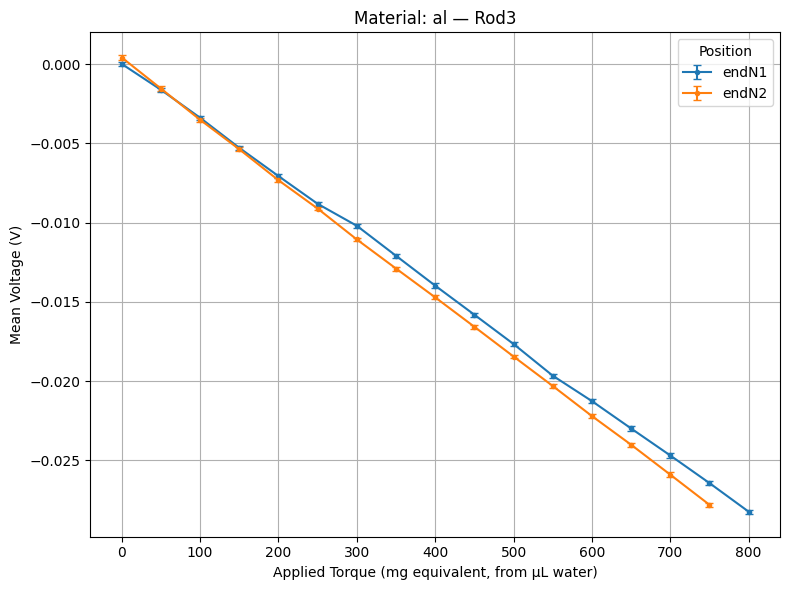

In [11]:
import matplotlib.pyplot as plt
# Unique combinations of material + rod
rod_groups = summary_df[['material', 'rod_id']].drop_duplicates()

for _, row in rod_groups.iterrows():
    mat = row['material']
    rod = row['rod_id']
    
    df_rod = summary_df[(summary_df['material'] == mat) & (summary_df['rod_id'] == rod)]
    
    fig, ax = plt.subplots(figsize=(8, 6))
    
    for pos in ['endN1', 'endN2']:
        df_pos = df_rod[df_rod['position'] == pos]
        
        ax.errorbar(
            df_pos['torque_mg'], 
            df_pos['mean_voltage'], 
            yerr=df_pos['std_voltage'], 
            label=pos,
            capsize=3,
            marker='o',
            markersize=3,
            linestyle='-'
        )
    
    ax.set_title(f'Material: {mat} — {rod}')
    ax.set_xlabel('Applied Torque (mg equivalent, from µL water)')
    ax.set_ylabel('Mean Voltage (V)')
    ax.legend(title='Position')
    ax.grid(True)
    plt.tight_layout()
    plt.show()

In [12]:
rod1_al = summary_df[
    (summary_df['material'] == 'al') &
    (summary_df['rod_id'] == 'Rod1')
].sort_values(by=['position', 'point_index'])

# Display the table
print(rod1_al[['position', 'point_index', 'torque_mg', 'mean_voltage', 'std_voltage']])

   position  point_index  torque_mg  mean_voltage  std_voltage
65    endN1            0          0      0.003626     0.000138
66    endN1            1         50      0.009111     0.000125
67    endN1            2        100      0.010475     0.000126
68    endN1            3        150      0.012441     0.000134
69    endN1            4        200      0.014733     0.000122
70    endN1            5        250      0.016002     0.000123
71    endN1            6        300      0.017266     0.000124
72    endN1            7        350      0.018096     0.000131
73    endN1            8        400      0.018825     0.000117
74    endN1            9        450      0.020582     0.000126
75    endN1           10        500      0.021337     0.000132
76    endN1           11        550      0.022778     0.000137
77    endN1           12        600      0.024583     0.000136
78    endN1           13        650      0.025741     0.000139
79    endN1           14        700      0.026563     0

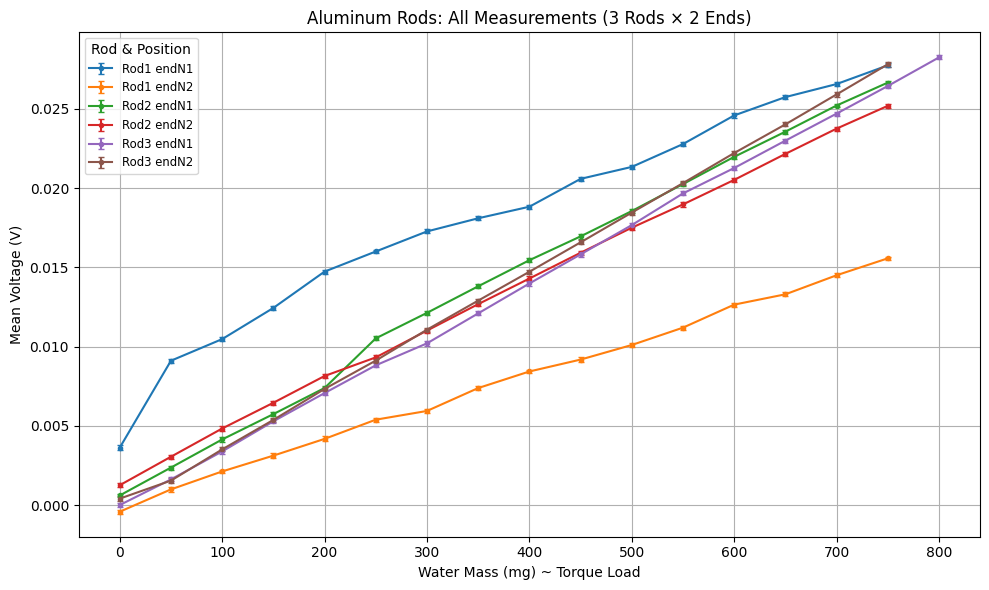

In [13]:
# Work on a copy to be safe
summary_df_corrected = summary_df.copy()

# Apply absolute to mean_voltage only for 'al' rods and only 'Rod3'
mask = (summary_df_corrected['material'] == 'al') & (summary_df_corrected['rod_id'] == 'Rod3')
summary_df_corrected.loc[mask, 'mean_voltage'] = summary_df_corrected.loc[mask, 'mean_voltage'].abs()

#filter aluminum after correction
al_df = summary_df_corrected[summary_df_corrected['material'] == 'al']

# Setup figure
fig, ax = plt.subplots(figsize=(10, 6))

# Define a consistent color cycle
colors = plt.cm.tab10.colors  # up to 10 distinct colors

# Extract unique (rod_id, position) pairs as a list of tuples and sort
unique_pairs = al_df[['rod_id', 'position']].drop_duplicates()
pairs_list = list(map(tuple, unique_pairs.values))
pairs_list = sorted(pairs_list)  # Sort alphabetically by rod_id then position

# Plot each line
for i, (rod, pos) in enumerate(pairs_list):
    df_subset = al_df[(al_df['rod_id'] == rod) & (al_df['position'] == pos)]
    
    ax.errorbar(
        df_subset['torque_mg'],
        df_subset['mean_voltage'],
        yerr=df_subset['std_voltage'],
        label=f'{rod} {pos}',
        capsize=2,
        marker='o',
        linestyle='-',
        markersize=3,
        color=colors[i % len(colors)]
    )

# Formatting
ax.set_title('Aluminum Rods: All Measurements (3 Rods × 2 Ends)')
ax.set_xlabel('Water Mass (mg) ~ Torque Load')
ax.set_ylabel('Mean Voltage (V)')
ax.grid(True)
ax.legend(title='Rod & Position', fontsize='small')
plt.tight_layout()
plt.show()


In [14]:
from scipy.optimize import curve_fit
import numpy as np

def linear_model(x, m, b):
    return m * x + b
    
def compute_sigma_eff(x_values, sigma_x, sigma_y, model_func, params):
    """
    Computes the effective standard deviation incorporating uncertainties in both x and y.

    Parameters:
    - x_values (array-like): Independent variable values.
    - sigma_x (array-like): Uncertainties in x_values.
    - sigma_y (array-like): Uncertainties in y_values.
    - model_func (function): Function defining the model.
    - params (tuple): Parameters of the model.

    Returns:
    - sigma_eff (array-like): Effective uncertainty combining sigma_x and sigma_y.
    """
    # Compute the derivative df/dx numerically
    delta_x = 1e-6  # Small step for numerical differentiation
    df_dx = (model_func(x_values + delta_x, *params) - model_func(x_values - delta_x, *params)) / (2 * delta_x)

    # Compute effective variance
    sigma_eff_squared = sigma_y**2 + (df_dx * sigma_x)**2
    return np.sqrt(sigma_eff_squared)

def perform_curve_fit(x_values, y_values, sigma_x, sigma_y, model_func, initial_guess):
    """
    Performs curve fitting considering uncertainties in both x and y.

    Parameters:
    - x_values (array-like): Independent variable values (observed).
    - y_values (array-like): Dependent variable values (observed).
    - sigma_x (array-like): Uncertainties in x_values.
    - sigma_y (array-like): Uncertainties in y_values.
    - model_func (function): Function defining the model.
    - initial_guess (tuple): Initial guess for model parameters.

    Returns:
    - popt (array): Optimal values for the parameters.
    - pcov (2D array): The estimated covariance of popt.
    """
    # Perform initial fit without sigma_x
    popt, pcov = curve_fit(model_func, x_values, y_values, sigma=sigma_y, absolute_sigma=True, p0=initial_guess)

    # Compute effective sigma with the best-fit parameters
    sigma_eff = compute_sigma_eff(x_values, sigma_x, sigma_y, model_func, popt)

    # Refit using effective sigma
    popt, pcov = curve_fit(model_func, x_values, y_values, sigma=sigma_eff, absolute_sigma=True, p0=popt)

    return popt, pcov

def compute_chi_squared(x_values, y_values, sigma_x, sigma_y, model_func, params):
    """
    Computes chi-squared and reduced chi-squared, incorporating both y and x uncertainties.

    Parameters:
    - x_values (array-like): Independent variable values (observed).
    - y_values (array-like): Dependent variable values (observed).
    - sigma_x (array-like): Uncertainties in x_values.
    - sigma_y (array-like): Uncertainties in y_values.
    - model_func (function): Function defining the model. (linear)
    - params (tuple): Parameters of the model. (Linear is 2)

    Returns:
    - chi_squared (float): The chi-squared value.
    - chi_squared_red (float): The reduced chi-squared value.
    """
    # Compute fitted y-values using the model function
    y_fit_values = model_func(x_values, *params)

    # Compute effective sigma
    sigma_eff = compute_sigma_eff(x_values, sigma_x, sigma_y, model_func, params)

    # Compute chi-squared
    chi_squared = np.sum(((y_values - y_fit_values) ** 2) / sigma_eff**2)

    # Degrees of freedom
    dof = len(y_values) - len(params)

    # Reduced chi-squared
    chi_squared_red = chi_squared / dof

    #print("Chi-Squared:", chi_squared)
    #print("Reduced Chi-Squared:", chi_squared_red)

    return chi_squared, chi_squared_red


In [15]:
import matplotlib.colors as mcolors

# Lambda for zero uncertainty in x (torque)
zero_sigma_x = lambda x: np.zeros_like(x)

# Function to generate visually related colors per rod
def get_rod_colors(unique_rods):
    base_colors = list(plt.cm.tab10.colors)
    color_dict = {}
    for i, rod in enumerate(unique_rods):
        base_color = np.array(base_colors[i % len(base_colors)])
        trial_colors = [
            tuple(np.clip(base_color * 0.8, 0, 1)),  # darker
            tuple(np.clip(base_color * 1.2, 0, 1)),  # lighter
        ]
        color_dict[rod] = trial_colors
    return color_dict

# Plotting function
def plot_material_with_fit(summary_df, material_name, model_func, initial_guess, save_path=None):
    df_mat = summary_df[summary_df['material'] == material_name]

    fig, ax = plt.subplots(figsize=(10, 6))
    
    unique_rods = df_mat['rod_id'].unique()
    rod_colors = get_rod_colors(unique_rods)
    
    pairs_list = list(map(tuple, df_mat[['rod_id', 'position']].drop_duplicates().values))
    pairs_list = sorted(pairs_list)

    for i, (rod, pos) in enumerate(pairs_list):
        df_subset = df_mat[(df_mat['rod_id'] == rod) & (df_mat['position'] == pos)]

        x = df_subset['torque_mg'].values
        y = df_subset['mean_voltage'].values
        sigma_y = df_subset['std_voltage'].values
        sigma_x = zero_sigma_x(x)

        # Fit curve
        popt, pcov = perform_curve_fit(x, y, sigma_x, sigma_y, model_func, initial_guess)

        # Chi-squared
        chi2, chi2_red = compute_chi_squared(x, y, sigma_x, sigma_y, model_func, popt)

        # Assign color based on rod & trial index
        trial_index = list(df_mat[df_mat['rod_id'] == rod]['position'].unique()).index(pos)
        color = rod_colors[rod][trial_index % 2]  # Use lighter/darker for trial A/B

        # Plot data
        ax.errorbar(x, y, yerr=sigma_y, label='_nolegend_', capsize=3, marker='o', linestyle='None', markersize=4, color=color)

        #formating for label
        trial_num = pos.replace('endN', '')  # Strip "endN", keep number
        m = popt[0]  # slope
        m_err = np.sqrt(pcov[0, 0])  # standard error of slope
        percent_err = abs(m_err / m) * 100 if m != 0 else np.nan

        # Fit curve
        x_fit = np.linspace(min(x), max(x), 200)
        y_fit = model_func(x_fit, *popt)
        ax.plot(x_fit, y_fit, linestyle='-', color=color,
                label = f'{rod}, Trial {trial_num}: m={m:.4e} (±{percent_err:.2f}%), χ²_red={chi2_red:.2f}')



    ax.set_title(f'{material_name.capitalize()} Rods: Data and Curve Fits')
    ax.set_xlabel('Water Mass (mg) ~ Torque Load')
    ax.set_ylabel('Mean Voltage (V)')
    ax.grid(True)
    ax.legend(fontsize='small', loc='best')
    plt.tight_layout()

    if save_path:
        filename = f"{save_path}/{material_name.replace(' ', '_')}_fit.png"
        plt.savefig(filename, dpi=300)
        print(f"Saved plot to: {filename}")
        
    plt.show()


Saved plot to: ./plots/al_fit.png


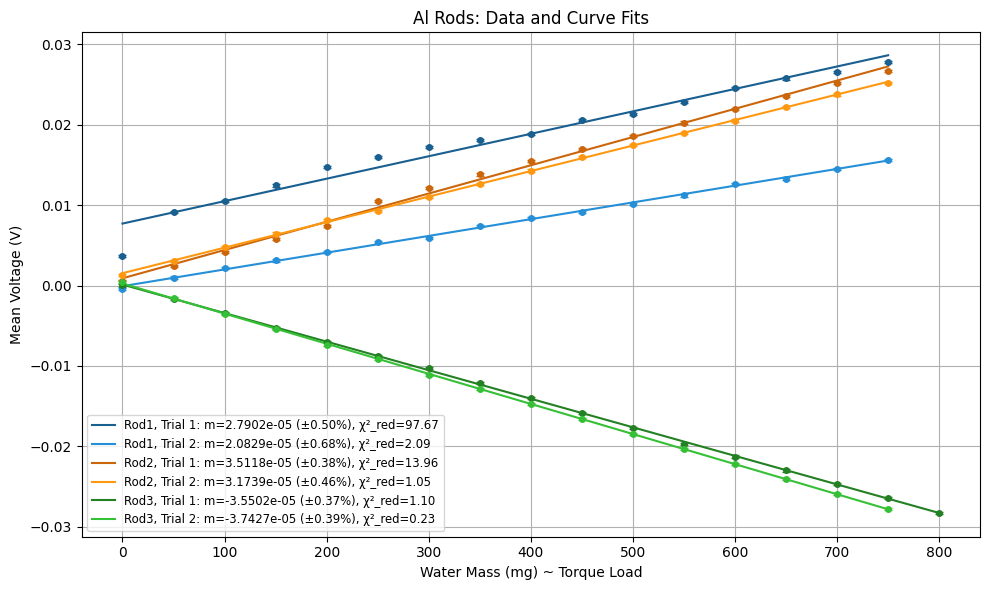

Saved plot to: ./plots/glass_fit.png


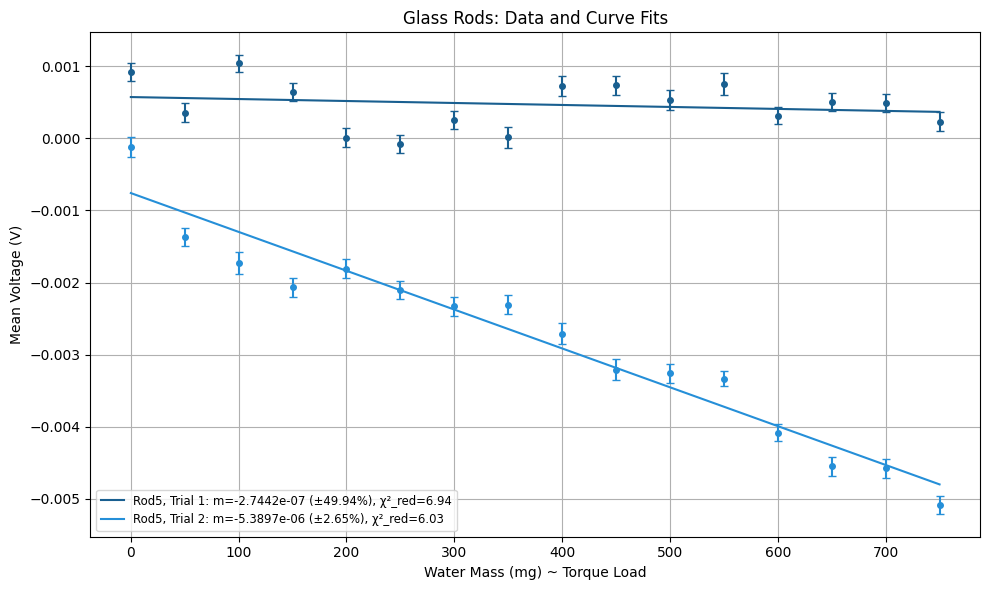

Saved plot to: ./plots/clear_plastic_fit.png


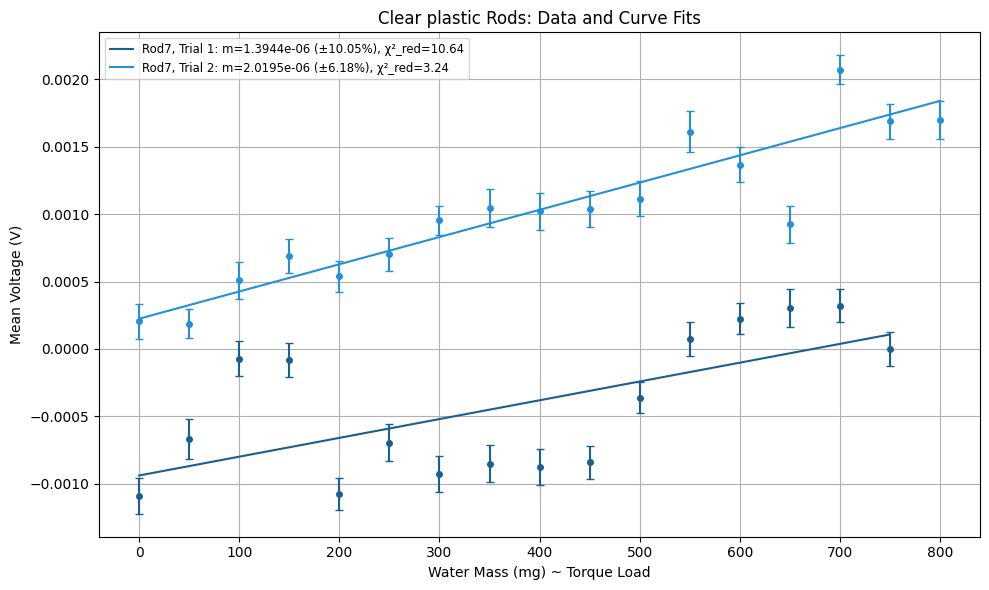

In [17]:
save_folder = "./plots"
initial_guess = (0, 0)

# For each material
plot_material_with_fit(summary_df, 'al', linear_model, initial_guess, save_path=save_folder)
plot_material_with_fit(summary_df, 'glass', linear_model, initial_guess, save_path=save_folder)
plot_material_with_fit(summary_df, 'clear plastic', linear_model, initial_guess, save_path=save_folder)
